In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [3]:
dir_abs  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7_dt10/'
dir_rel  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'

file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [4]:
#get fields psi
pfile_abs = dir_abs + file0
pfile_rel = dir_rel + file0

toc_file_abs = dir_abs + file1
toc_file_rel = dir_rel + file1


f_abs = netcdf.netcdf_file(dir_abs + file0,'r')
f_rel = netcdf.netcdf_file(dir_rel + file0,'r')

In [5]:
si_t = f_abs.variables['time'][:].copy().size

p = qg.read_qgcm(pfile_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nz,ny,nx = p.shape

test = si_t

average = True

In [6]:
# flot moyen abs
flot_me = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/termes_flot_moyen_abs.npz')
u_me_abs = flot_me['u_me']
v_me_abs = flot_me['v_me']

flot_me_bis = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/etapes_flot_moyen_abs.npz')
         
p_me_abs = flot_me_bis['p_me']
b_me_abs = flot_me_bis['b_me']
w_me_abs = flot_me_bis['w_me']


In [7]:
k,fl = qg.get_spec_flux(psi1 = p_me_abs, psi2 = p_me_abs, Delta=Delta)
fl_z = integral_z(psi = fl, dh=dh, Delta=Delta, Ht=Ht_b)
n_k = fl_z.shape

In [8]:
#uninterp b_me with diff
dbdx_me_abs = np.diff(b_me_abs,1,2)/Delta
dbdy_me_abs = np.diff(b_me_abs,1,1)/Delta


#compute the expression sparately with padding to obtain (513,512)ish arrays
dbdx_pad_abs = np.pad(dbdx_me_abs,((0,0),(0,0),(1,1)))
dbdy_pad_abs = np.pad(dbdy_me_abs,((0,0),(1,1),(0,0)))

#uninterp u_me and v_me with diff
dudx_me_abs = np.diff(u_me_abs,1,2)/Delta
dudy_me_abs = np.diff(u_me_abs,1,1)/Delta
dvdx_me_abs = np.diff(v_me_abs,1,2)/Delta
dvdy_me_abs = np.diff(v_me_abs,1,1)/Delta
#compute the expression sparately with padding to obtain (513,512)ish arrays
dudx_pad_abs = np.pad(dudx_me_abs,((0,0),(0,0),(1,1)))
dudy_pad_abs = np.pad(dudy_me_abs,((0,0),(1,1),(0,0)))
dvdx_pad_abs = np.pad(dvdx_me_abs,((0,0),(0,0),(1,1)))
dvdy_pad_abs = np.pad(dvdy_me_abs,((0,0),(1,1),(0,0)))

In [9]:
u_me_abs_i = integral_z(u_me_abs, dh, Delta, Ht)
v_me_abs_i = integral_z(v_me_abs, dh, Delta, Ht)

In [19]:
fl_eke_me = np.zeros((n_k))
fl_mke_me = np.zeros((n_k))

n_me=1

#for it in range(0,test):
p_abs = qg.read_qgcm(pfile_abs, 100, var='p', rescale = 1/f0, interp = True, subtract_bc = True)

u_abs,v_abs = qg.comp_vel(p_abs, Delta=Delta, loc='center')
b_abs = qg.p2b(p_abs, dh, f0)

u_p_abs = u_abs - u_me_abs
v_p_abs = v_abs - v_me_abs
b_p_abs = b_abs - b_me_abs
p_p_abs = p_abs - p_me_abs

u_p_abs_use = reduce_z_dim(u_p_abs, dh)
v_p_abs_use = reduce_z_dim(v_p_abs, dh)

du2_dx_abs = np.diff(u_p_abs**2, 1,2)/Delta
duv_dy_abs = np.diff(u_p_abs*v_p_abs,1,1)/Delta
duv_dx_abs = np.diff(u_p_abs*v_p_abs,1,2)/Delta
dv2_dy_abs = np.diff(v_p_abs**2, 1,1)/Delta

du2_dx_pad_abs = np.pad(du2_dx_abs,((0,0),(0,0),(1,1)))
duv_dy_pad_abs = np.pad(duv_dy_abs,((0,0),(1,1),(0,0)))
duv_dx_pad_abs = np.pad(duv_dx_abs,((0,0),(0,0),(1,1)))
dv2_dy_pad_abs = np.pad(dv2_dy_abs,((0,0),(1,1),(0,0)))

eke2mke_abs = 0.5*((du2_dx_pad_abs[:,:,1:]+du2_dx_pad_abs[:,:,:-1])*u_me_abs 
              +(duv_dy_pad_abs[:,1:,:]+duv_dy_pad_abs[:,:-1,:])*u_me_abs
              +(duv_dx_pad_abs[:,:,1:]+duv_dx_pad_abs[:,:,:-1])*v_me_abs
              +(dv2_dy_pad_abs[:,1:,:]+dv2_dy_pad_abs[:,:-1,:])*v_me_abs)

mke2eke_abs = 0.5*((dudx_pad_abs[:,:,1:]+dudx_pad_abs[:,:,:-1])*u_p_abs**2 
          +(dudy_pad_abs[:,1:,:]+dudy_pad_abs[:,:-1,:])*u_p_abs*v_p_abs
          +(dvdx_pad_abs[:,:,1:]+dvdx_pad_abs[:,:,:-1])*u_p_abs*v_p_abs
          +(dvdy_pad_abs[:,1:,:]+dvdy_pad_abs[:,:-1,:])*v_p_abs**2)

eke_1 = 0.5*(du2_dx_pad_abs[:,:,1:]+du2_dx_pad_abs[:,:,:-1])
eke_2 = 0.5*(duv_dy_pad_abs[:,1:,:]+duv_dy_pad_abs[:,:-1,:])
eke_3 = 0.5*(duv_dx_pad_abs[:,:,1:]+duv_dx_pad_abs[:,:,:-1])
eke_4 = 0.5*(dv2_dy_pad_abs[:,1:,:]+dv2_dy_pad_abs[:,:-1,:])

k_eke_1, fl_eke_1 = qg.get_spec_flux(psi1 = u_me_abs, psi2 = eke_1, Delta=Delta )
k_eke_2, fl_eke_2 = qg.get_spec_flux(psi1 = u_me_abs, psi2 = eke_2, Delta=Delta )
k_eke_3, fl_eke_3 = qg.get_spec_flux(psi1 = v_me_abs, psi2 = eke_3, Delta=Delta )
k_eke_4, fl_eke_4 = qg.get_spec_flux(psi1 = v_me_abs, psi2 = eke_4, Delta=Delta )

mke_1 = integral_z(0.5*(dudx_pad_abs[:,:,1:]+dudx_pad_abs[:,:,:-1]),dh, Delta, Ht)
mke_2 = integral_z(0.5*(dudy_pad_abs[:,1:,:]+dudy_pad_abs[:,:-1,:]),dh, Delta, Ht)
mke_3 = integral_z(0.5*(dvdx_pad_abs[:,:,1:]+dvdx_pad_abs[:,:,:-1]),dh, Delta, Ht)
mke_4 = integral_z(0.5*(dvdy_pad_abs[:,1:,:]+dvdy_pad_abs[:,:-1,:]),dh, Delta, Ht)

mke_u2_p = u_p_abs**2
mke_uv_p = u_p_abs*v_p_abs
mke_v2_p = v_p_abs**2
                   
k_mke_1, fl_mke_1 = qg.get_spec_flux(psi1 = mke_1, psi2 = mke_u2_p, Delta=Delta )
k_mke_2, fl_mke_2 = qg.get_spec_flux(psi1 = mke_2, psi2 = mke_uv_p, Delta=Delta )
k_mke_3, fl_mke_3 = qg.get_spec_flux(psi1 = mke_3, psi2 = mke_uv_p, Delta=Delta )
k_mke_4, fl_mke_4 = qg.get_spec_flux(psi1 = mke_4, psi2 = mke_v2_p, Delta=Delta )
    
fl_eke = integral_z(fl_eke_1+fl_eke_2+fl_eke_3+fl_eke_4, dh, Delta, Ht)
fl_mke = integral_z(fl_mke_1+fl_mke_2+fl_mke_3+fl_mke_4, dh, Delta, Ht)
                       
#    fl_eke_me += (fl_eke - fl_eke_me)/n_me
#    fl_mke_me += (fl_mke - fl_mke_me)/n_me
                       
#    n_me+=1

In [13]:
def forward(x):
    return 1/x

def inverse(x):
    return 1/x

<ipython-input-13-711fb66c38b2>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1/x


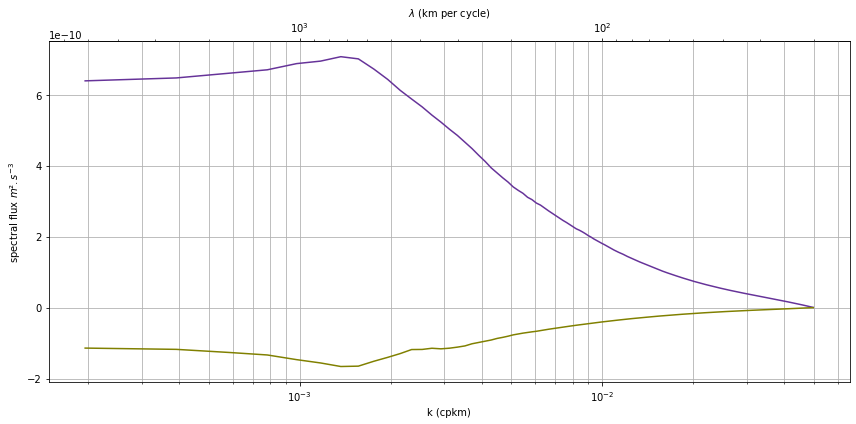

In [14]:
fig, ax2 = plt.subplots(1, 1, figsize = (12,6),tight_layout=True)


ax2.plot(k_eke_1*1e3, fl_eke_me, color = 'rebeccapurple')
ax2.plot(k_mke_1*1e3, fl_mke_me, color = 'olive')
#ax2.set_title('bottom drag')
ax2.set_xlabel('k (cpkm)')
ax2.set_ylabel(r'spectral flux $m².s^{-3}$')
ax2.set_xscale('log')
secax2 = ax2.secondary_xaxis('top', functions = (forward, inverse))
secax2.set_xlabel(r'$\lambda$ (km per cycle)')
ax2.grid(True, which = 'both')